## Estimating the Bondi accretion rate based on real input parameters
With this code you will:
* Import your (ALMA CO and Keck/OSIRIS) data
* Create a nice looking image of that data
* Translate integrated CO fluxes to molecular gas mass, convert that to spherical density
* Estimate sound speed (based on temperatures calculated externally)
* Calculate intrinsic luminosity using X-ray data
* Estimate accretion rate using the intrinsic luminosity
* Plot Bondi accretion rate vs. X-ray accretion rate

In [7]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.patches as patches
from matplotlib.patches import Ellipse as pltEllipse
from matplotlib.patches import Rectangle as pltRectangle
import astropy.io as apy
from astropy.io import fits
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Constants
msolar = 1.99e30
k = 1.38066e-16 #boltzmann constant (in cm units)
mu = 2.7# molecular gas with 10% He and trace metals
m_p = 1.6726e-24 #proton mass kg
G = 6.6743e-11
D_L = 13.48 #luminosity distance, Mpc
#galaxy info
redshift = 0.003793 #galaxy redshift 
pixsize = 0.0065 #pixel size in arcsec for your ALMA data (see header)
pcperarcsec  = D_L*(4.85e-6)*(1e6) #small angle approximation, in Mpc
padeg = 36 #Restoring beam PA (deg), check header
pa = 2*np.pi*padeg/360 #in radians
pixper100pc = (100/pcperarcsec/pixsize)
print(pixper100pc)

235.31792628430637


In [14]:
# Initializing CO data
# This data can be found at https://github.com/jagostino-code/measure_bhar/blob/main/NGC1068_CO.fits.moment0
data_path = '/home/james/Desktop/research/gasphysics/NGC1068/data/Bondi_tutorial/'
figure_path = 'Bondi_tutorial/figures/' #path to where you want to save your figures
filename = data_path+'NGC1068_CO.fits.moment0' #your moment 0 map (not masked)
cofile = apy.fits.open(filename,memmap=False)
coheader = cofile[0].header
codata = cofile[0].data
comap = codata[0][0] #initialize the data, this is your moment 0 map now in y, x




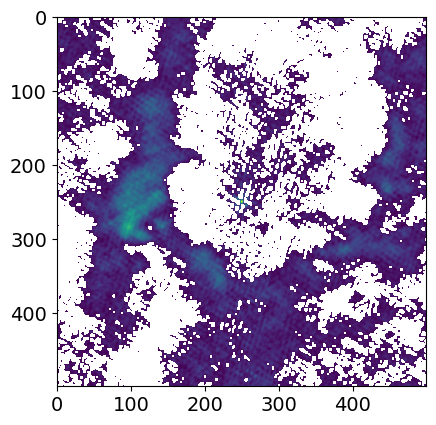

In [15]:
# Let's check to make sure this is the data we expect to be using
# Don't stress about the yaxis, we'll invert it in the next cell 
plt.rc('ytick', labelsize=14) 
plt.rc('xtick', labelsize=14) 
## If your moment map is not centered on continuum center, make sure below aligns with that location##
# Can check this by opening both the moment map and continuum map in CARTA and spatially matching the two with a pixel on continuum center
xpix = 749 #0 indexed, image size is 1500x1500 (0:1499x1499)
ypix = 749 #
data = comap[ypix-250:ypix+250,xpix-250:xpix+250] #500 x 500 box, adjust steps for a larger FoV
rms_co = 0.25e-3 #ideally you want to measure this in the non-primary beam corrected CO cube, not the moment map
loc = np.where(data<(3*rms_co))
data[loc] = np.nan
plt.imshow(data)

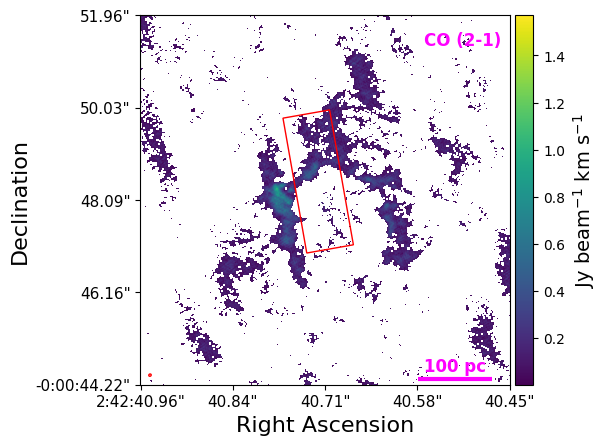

In [16]:
#Lets also plot a nice version of this with RA/Dec coordinates 
#WCS bounds are 2:42:40.8172666536" (RA) -0:00:49.5693999998 (Dec)
#(for NGC 1068) 2:42:40.6005999813" (RA) -0:00:46.3193999964 (Dec)
#on axes I want to only label the seconds, it'll be in 5 steps
#steps are
npc = 500 #parsec value you want to go out to in r
npix = npc/pcperarcsec/pixsize #value to go out to in r by 
npixint = int(npix)
npixinthalf = int(0.5*npixint)
data = comap[ypix-npixinthalf:ypix+npixinthalf,xpix-npixinthalf:xpix+npixinthalf] #the box we want to look in, centered on continuum center
#you might want a smaller region -- if so you'll want to edit the above, then you'll need to change the label locs too
loc = np.where(data<(3*rms_co))
data[loc] = np.nan #mask anything negative into NaNs for plotting, negative = oversubtracted


#use the below if you want to automatically label your tick markers (RA/Dec); otherwise can skip the next 7 lines
rastep = (817.3-600.6)/-5 #RA bounds divided by the # of axis labels you want plotted
decstep = (49.57-46.32)/5
rafzw = []
decfzw = []
for i in range(0,6):
    rafzw.append(str(int(rastep*i)+600)) #plus the initial 0.6" in RA
    decfzw.append(str(int((decstep*i)+46))) #plus the initial 46s in Dec

xticklocs = [0,294,587,881,1175] 
yticklocs = [0,294,587,881,1175]
#uncomment 2 lines below, comment the following 2 lines if you are automatically labeling tick markers
#xlabels2d = ['2:42:40.'+rafzw[0]+'"','40.'+rafzw[1]+'"','40.'+rafzw[2]+'"','40.'+rafzw[3]+'"','40.'+rafzw[4]+'"','40.'+rafzw[5]+'"']
#ylabels2d = ['0:00:46.32"','46.'+decfzw[1]+'"','47.'+decfzw[2]+'"','46.'+decfzw[3]+'"','46.'+decfzw[4]+'"','46.'+decfzw[5]+'"']
xlabels = ['2:42:40.96'+'"','40.84"','40.71"','40.58"','40.45"'] #manual labels for RA
ylabels = ['-0:00:44.22"','46.16"', '48.09"','50.03"','51.96"'] #manual labels for Dec

fig = plt.figure()
ax = fig.subplots()
ax.set_xticks(xticklocs) #setting location of ticks
ax.set_yticks(yticklocs)
ax.set_xticklabels(xlabels, fontsize = 11) #setting tick labels
ax.set_yticklabels(ylabels, fontsize = 11)

ax.set_xlabel('Right Ascension', fontsize = 16)
ax.set_ylabel('Declination', fontsize = 16)
ax.imshow(data)

#if you wanted to plot contours, you could use something like the following 5 lines
#keep in mind "comap" here is the (2-1) data, but you could use continuum or something else
#levels = [0.2,0.75]
#ax.contour(comap, levels=np.logspace(-4.2, -1, 7), cmap = 'gray', alpha=0.6, linewidths = 1.5) #stop start #
#levels are 10^-4.2 - 10^-1, 10 steps
#ax.contour(data, levels= [(3*rmsJy),(6*rmsJy), (12*rmsJy),(24*rmsJy),(48*rmsJy)], colors = 'white', alpha=0.8, linewidths = 1.5) #stop start #
#ax.contour(data, levels= levels, colors = 'white', alpha=0.8, linewidths = 0.5) #stop start #

#ax.hlines(17,945,1136, color = 'magenta',linewidth = 3)
textloc = npix*0.75
ax.hlines(17,textloc,textloc+pixper100pc, color = 'magenta',linewidth = 3)

#center your text on the hline above using the offset in x (~20 in this case)
ax.text(textloc+20,43,'100 pc',color = 'magenta',fontweight = 'bold',fontsize = 12)
ax.text(textloc+20,1080,'CO (2-1)',color = 'magenta',fontweight = 'bold',fontsize = 12)

im = plt.imshow(data)
divider = make_axes_locatable(ax) #so you can move the axes around
ax.invert_yaxis()
ellipse = pltEllipse((30, 30), 8, 7, angle=padeg, alpha=1, fill = False, color = 'red') #drawing the beam
ax.add_artist(ellipse)
keck2alma = 5.38 # number of ALMA pixels in a keck pixel
#keckfov plots a rectangle representing the Keck/OSIRIS FoV. The first 3 inputs are xy, width, height. OSIRIS has a 28 x 81 pixel FoV
#angle will vary, and you should double-check in CARTA that the result here matches 
#the offsets of (4*keck2alma) and (9*keck2alma) exist because the AGN is not centered in the frame of the keck FoV
keckfov = pltRectangle([npixinthalf- (4*keck2alma)-(14*keck2alma/2),npixinthalf+(9*keck2alma)-(81*keck2alma/2)],28*keck2alma,81*keck2alma,ec='red',fill=None, angle = 10)

ax.add_artist(keckfov)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax = cax, ax = data)

cbar.ax.tick_params(axis="both", labelsize=12)
cbar.set_label(label = 'Jy beam$^{-1}$ km s$^{-1}$', size=14)
cbar.ax.tick_params(axis="both", labelsize=12)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.savefig(figure_path+"NGC1068_co21_moment0.png", dpi=300)


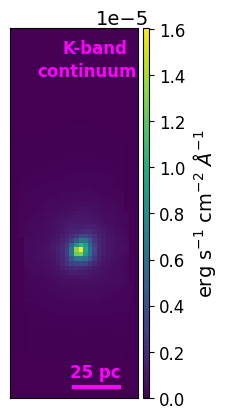

In [12]:
#Now lets make figures for the K-band data (Keck/OSIRIS)
#files for these next 2 cells can be found at: https://github.com/jagostino-code/measure_bhar

pcperpix = 0.035*pcperarcsec #pc/pix
pix25 = 25/pcperpix#pix for 100 pc
H2file = 'NGC1068_mosaic_Kbb_035_fluxcalib.moment0.fits' #this is the K-band line+continuum (in delta_nu units)
H2data = apy.fits.open(H2file,memmap=False)
H2header = H2data[0].header
H2data = H2data[0].data
v_high = 152566e9 #Hz
v_low = 125910e9 #Hz
dataH2 = H2data[0][0:][0:]/(v_high-v_low) #converting to correct units, removing the delta_nu
fig = plt.figure()
ax = fig.subplots()
divider = make_axes_locatable(ax)
im = plt.imshow(dataH2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax = cax, ax = data)
cbar.ax.tick_params(axis="both", labelsize=12)
cbar.set_label(label = 'erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$', size=14)
cbar.ax.tick_params(axis="both", labelsize=12)
ax.invert_yaxis()
ax.hlines(2,13,13+pix25, color = 'magenta',linewidth = 3)
ax.text(12.75,4,'25 pc',color = 'magenta',fontweight = 'bold',fontsize = 12)
ax.text(11,75,'K-band',color = 'magenta',fontweight = 'bold',fontsize = 12)
ax.text(5.5,70,'continuum',color = 'magenta',fontweight = 'bold',fontsize = 12)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig(figure_path+'NGC1068_kband_line_continuum.png',dpi=300)

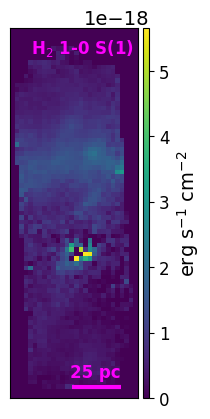

In [13]:
H2file = 'ngc1068-QFitsView-H2-1-0-S1.fits' # H2 1-0 S(1) 
H2data = apy.fits.open(H2file,memmap=False)
H2header = H2data[0].header
H2data = H2data[0].data
dataH2 = H2data
fig = plt.figure()
ax = fig.subplots()
divider = make_axes_locatable(ax)
im = plt.imshow(H2data, vmin=0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax = cax, ax = data)
cbar.ax.tick_params(axis="both", labelsize=12)
cbar.set_label(label = 'erg s$^{-1}$ cm$^{-2}$', size=14)
cbar.ax.tick_params(axis="both", labelsize=12)
ax.invert_yaxis()
ax.text(12.75,4,'25 pc',color = 'magenta',fontweight = 'bold',fontsize = 12)
ax.text(4,75,'H$_2$ 1-0 S(1)',color = 'magenta',fontweight = 'bold',fontsize = 12)
ax.hlines(2,13,13+pix25, color = 'magenta',linewidth = 3)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig(figure_path+'NGC1068_H2S1.png',dpi=300)

# Time for some Analysis! 
In this next cell you'll convert CO(2-1) line luminosity into H$_2$ + Helium mass, then convert that mass into a surface density in case you're interested in that

Running this will take some time (expect ~10 mins), depending on your region size and spatial resolution. 

In [17]:
#comap is the data cube. Lets re-initialize here just as a reminder:
filename = data_path+'NGC1068_CO.fits.moment0' #your moment 0 map (not masked)
cofile = apy.fits.open(filename,memmap=False)
coheader = cofile[0].header
codata = cofile[0].data
comap = codata[0][0] #initialize the data, this is your moment 0 map now in y, x
#re-defining some things as a reminder:
D_L = 13.48 #luminosity distance, Mpc
redshift = 0.003793 #galaxy redshift 
pixsize = 0.0065 #pixel size in arcsec
pcperarcsec  = D_L*(4.85e-6)*(1e6) #small angle approximation, in Mpc
npc = 500 #parsec value you want to go out to in r
npix = npc/pcperarcsec/pixsize 
npixint = int(npix)
npixinthalf = int(0.5*npixint)
rms_co = 0.25e-3 # in Jy, measure in .image NOT PBCOR, check statistics widget in large region without emission present
#####################################################
rrange = range(npixint) #radius range in pixels -- this determines the spatial dimensions of your analysis
xpix = 750-1 #central pix, usually place this on continuum center if image not centered
ypix = 750-1 # if image centered, do image size - 1
data = comap[ypix-npixinthalf:ypix+npixinthalf,xpix-npixinthalf:xpix+npixinthalf] #the box we want to look in, centered on continuum center
loc = np.where(data<(3*rms_co))
data[loc] = 0 #mask anything negative, negative = oversubtracted for interferometry

print(str(pcperarcsec) + ' pc per arcsecond')
conv = pcperarcsec*pixsize # 
fourpi = 4*np.pi
v_obs = 230.132 #observed freq in GHz, can check moment 0 header for this
rF = []
for i in range(len(rrange)):
    r = rrange[i]
    rF.append(r)

fwhm_minor = 3600*coheader['BMIN']/2 #header has the beam sizes in degrees so converting to arcsec
fwhm_major = 3600*coheader['BMAJ']/2

beamarea = np.pi/4/np.log(2)*fwhm_minor*fwhm_major/(pixsize**2) #to grab this value look in CASA imview or from the weblog, otherwise calculate it like this


#constants
pc2msq = 9.521e+32 #parsecs to meters squared
##########

#Here's how you can calculate r21 if you have a CO(1-0) image that has matched resolution to CO (2-1) in the region of interest
#keep these lines commented out if you don't have these data #############
#LCO1 = 7.334e-1 #flux density from rectangular reg. in viewer for CO1-0. Use the same coords for both 1-0 and 2-1.
#LCO2 = 2.264e0 #same for CO(2-1). You can save region files in CARTA to make sure you measure in the same regions
#e_LCO1 = x
#e_LCO2 = y
#v_obs1 = 109.8729 #look at header for CO(1-0)
#v_obs2 = 219.6898 #look at header for CO(2-1)
#L1 = (3.25e7)*LCO1*((v_obs1)**-2)*((D_L)**2)*((1+redshift)**-3)
#e_L1 = (3.25e7)*(LCO1*0.05)*((v_obs1)**-2)*((D_L)**2)*((1+redshift)**-3) #0.05 -> 5% absolute flux uncertainty in Band 6 (see technical handbook)
#L2 = (3.25e7)*LCO2*((v_obs2)**-2)*((D_L)**2)*((1+redshift)**-3)
#e_L2 = (3.25e7)*(LCO2*0.1)*((v_obs2)**-2)*((D_L)**2)*((1+redshift)**-3) #0.1 -> 10% absolute flux uncertainty in Band 3 (see technical handbook)
#r21 = L2/L1
#e_r21 = r21*np.sqrt(((e_L1/L1)**2)+(e_L2/L2)**2) #propagate your uncertainties

r21 = 2.15 #r2->1 #from Viti+14 (https://www.aanda.org/articles/aa/pdf/2014/10/aa24116-14.pdf) for NGC 1068
e_r21 = np.sqrt(0.2)
alpha_CO = 4.3/r21 #4.3 is the alpha_CO(1-0) for Milky Way, see Bolatto+13 (https://ui.adsabs.harvard.edu/abs/2013ARA%26A..51..207B/abstract)
e_alpha_CO_10 = 4.3*0.3 #uncertainty on Milky Way alpha_CO(1-0)
e_alpha_CO_21 = alpha_CO*np.sqrt((e_alpha_CO_10/4.3)**2 + (e_r21/r21)**2)
print(str(alpha_CO) + ' alpha_CO(2-1) (rounded)')
######################################################

#L_CO to mass if you do not have matched resolution CO(1-0) OR r21 from other literature. 
#This just assumes the r21 from Cicone et al. 2018 (https://iopscience.iop.org/article/10.3847/1538-4357/aad32a)
#alpha_CO = 1.83 # can also be found in Medling et al. 2019 (https://iopscience.iop.org/article/10.3847/2041-8213/ab4db7/pdf)
#e_alpha_CO_21 = 0.97



sma = np.arange(0.5,npixint,0.5) #pix, circle with diameter of 1 pix to start (sma = semi-major axis)
sma_pc = sma*conv #sma in pc
padeg_nucleus = 107 #took the torus PA from Garcia-Burillo 2019
pa_nucleus = 2*np.pi*padeg/360 #in radians, change the 270 to your PA in deg
#pa doesn't make a difference with a circle, but including it here if you want an ellipse at some point
eps = 0 #circle
#ok, initialize some lists for your calcs in the for loop
L_CO_a = []  #CO luminosity
M_mol_a =[]  #molecular gas mass, solar masses
e_M_mol_a = []  #uncertainty in molecular gas mass, solar masses
ellipseareapix_a = []  #area of ellipse (circle) in pix
ellipseareapc_a = []   #area of ellipse (circle) in pc
aper_a = []  #aperture information (EllipticalAperture)
fdens_a = [] #flux density inside aperture
sfdens_a = [] #molecular solar masses per meter squared
sfdenspc2_a = [] #molecular solar masses per parsec squared
#for a range of semi-major axis values
from photutils.isophote import Ellipse
from photutils.aperture import aperture_photometry
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#Parent page for photutils_aperture here https://photutils.readthedocs.io/en/latest/user_guide/aperture.html
#Parent page for photutils_isophote here https://photutils.readthedocs.io/en/latest/user_guide/isophote.html


for i in range(len(sma)):    
    #Define the geometry parameters for your aperture
    geometry = EllipseGeometry(sma =sma[i],x0 = (npixinthalf),y0=npixinthalf, eps=eps,pa=pa_nucleus)
    #Define your aperture using those parameters
    aper = EllipticalAperture((geometry.x0,geometry.y0),geometry.sma,geometry.sma*(1-geometry.eps),geometry.pa)
    aper_a.append(aper)
    phot_table = aperture_photometry(data, aper)
    fdens = phot_table['aperture_sum']/beamarea #flux density inside radius i
    fdens_a.append(fdens)
    L_CO = (3.25e7)*fdens*((v_obs)**-2)*((D_L)**2)*((1+redshift)**-3) #Line luminosity
    L_CO_a.append(L_CO)
    M_mol = L_CO*alpha_CO
    M_mol_a.append(M_mol)
    e_M_mol  = L_CO*e_alpha_CO_21
    e_M_mol_a.append(e_M_mol)
    semiminor = sma[i]*np.sqrt(1-eps**2) #equal to sma for a circle :) 
    ellipseareapix = np.pi*sma[i]*semiminor #pi * a * b, in pix**2
    ellipseareapix_a.append(ellipseareapix)
    ellipseareapc = ellipseareapix*(conv**2) #(pc/arcsec*arcsec/pix)**2 = pix**2 * [(pc**2)/(pix**2)] = pc**2
    ellipseareapc_a.append(ellipseareapc)
    ellipseaream = ellipseareapc*pc2msq #in meters squared
    sfdens = M_mol/ellipseaream #molecular gas mass surface density (solar masses per meter squared)
    sfdens_a.append(sfdens)
    sfdenspc2 = M_mol/ellipseareapc #molecular gas mass surface density (solar masses per pc squared)
    sfdenspc2_a.append(sfdenspc2)

65.37800000000001 pc per arcsecond
2.0 alpha_CO(2-1) (rounded)


100.07737350000002 sma length in pc
   aperture_sum  
-----------------
1853.210055797561
   aperture_sum  
-----------------
408630968.7078477 H2+He mass inside the aperture
   aperture_sum  
-----------------
149173605.2608418 uncertainty in H2+He mass inside the aperture


(<matplotlib.patches.Ellipse at 0x7f1b4d265dc0>,)

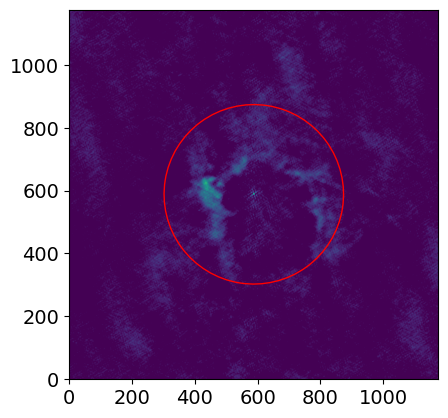

In [18]:
#check your work! We'll print out values in a circle with r = 100 pc 
print(str(sma_pc[470]) + ' sma length in pc')
print(str(fdens_a[470]))
print(str(M_mol_a[470]) + ' H2+He mass inside the aperture') #mass inside the aperture
print(str(e_M_mol_a[470]) + ' uncertainty in H2+He mass inside the aperture')
plt.figure()
plt.imshow(data,origin='lower')
aper_a[470].plot(color='red') #should show a region at 100 pc in radius (varies for each source)

Text(0.5, 0, 'Distance from center (pc)')

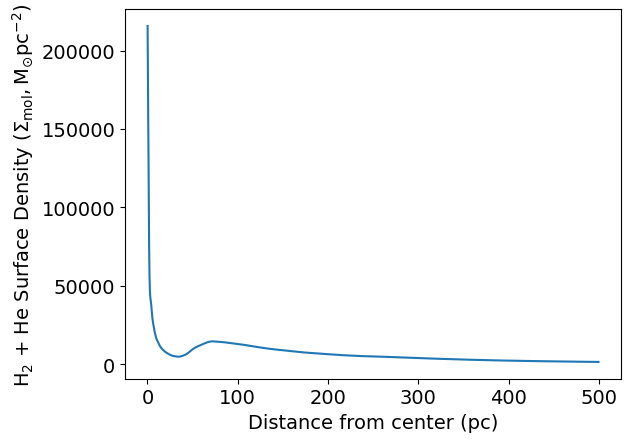

In [79]:
#plot the surface density if you want, is a good check to see if your geometry is correct. Look at where
#the overdensities are in your moment map, see if fluctuations in your surface density matches those regions
#the jump here at 75~ pc matches the start of the CND
plt.plot(sma_pc, sfdenspc2_a)
plt.ylabel('H$_2$ + He Surface Density ($\Sigma_{\mathrm{mol}}, \mathrm{M}_{\odot} \mathrm{pc}^{-2}$)', fontsize = 14)
plt.xlabel('Distance from center (pc)', fontsize = 14)

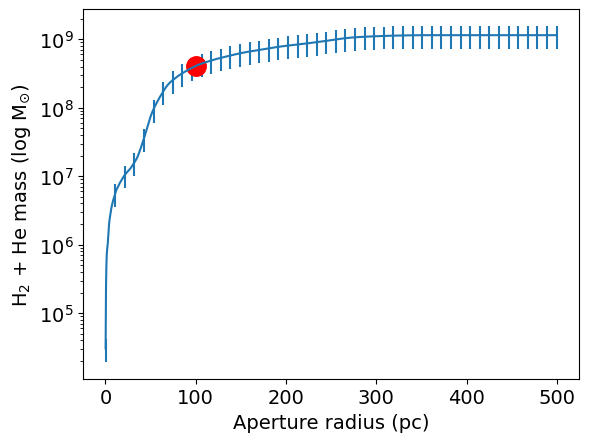

In [91]:
#Enclosed molecular gas mass profile for fun and/or input to your paper
#temporary arrays for plotting -- the initial output arrays have the labels from photutils which make them annoying
#for indexing
temp_x = []
temp_y = []
temp_y_err = []
for i in range(len(e_M_mol_a)):
    temp_y_err.append(float(e_M_mol_a[i]))
    temp_y.append(float(M_mol_a[i]))
    temp_x.append(float(sma_pc[i]))

plt.errorbar(temp_x, temp_y, xerr =None, yerr =temp_y_err,errorevery=50)
plt.ylabel('H$_2$ + He mass (log $\mathrm{M}_{\odot}$)', fontsize = 14)
plt.xlabel('Aperture radius (pc)', fontsize = 14)
plt.yscale('log')
plt.plot(sma_pc[470],M_mol_a[470], 'ro', markersize = 14) #100 pc


In [93]:
#initialize some more lists for later -- we'll need masses and densities in kg and distances in meters
#extension _B = _Bondi. This is using a spherical geometry. 
M_mol_a_B = [] #in kg
e_M_mol_a_B =[]
for i in range(len(M_mol_a)):
    M_mol_a_B.append(M_mol_a[i]*msolar)
    e_M_mol_a_B.append(e_M_mol_a[i]*msolar)
r_B = sma_pc*3.086e16 #pc->meters for later
r_B_cm = sma_pc*3.086e18
rho_B = []
rho_B_cm = []
for i in range(len(M_mol_a_B)):
    rho_B_i = M_mol_a_B[i]/(4/3*np.pi*r_B[i]**3) #kg m^-3
    rho_B.append(rho_B_i)
    rho_B_i_cm = M_mol_a_B[i]/(4/3*np.pi*r_B_cm[i]**3) #kg cm^-3
    rho_B_cm.append(rho_B_i_cm)

e_rho_B = [] #kg m^-3
for i in range(len(M_mol_a_B)):
    e_rho_B_i = e_M_mol_a_B[i]/(4/3*np.pi*r_B[i]**3) #kg m^-3
    e_rho_B.append(e_rho_B_i)

rho_norm = [] #'norm' = normal
for i in range(len(M_mol_a)):
    rho_norm_i = M_mol_a[i]/(4/3*np.pi*sma_pc[i]**3) #Msolar pc^-3
    rho_norm.append(rho_norm_i)
e_rho_norm = []
for i in range(len(M_mol_a)):
    e_rho_norm_i = e_M_mol_a[i]/(4/3*np.pi*sma_pc[i]**3) #Msolar pc^-3
    e_rho_norm.append(e_rho_norm_i) 

Text(0.5, 0, 'Aperture radius (pc)')

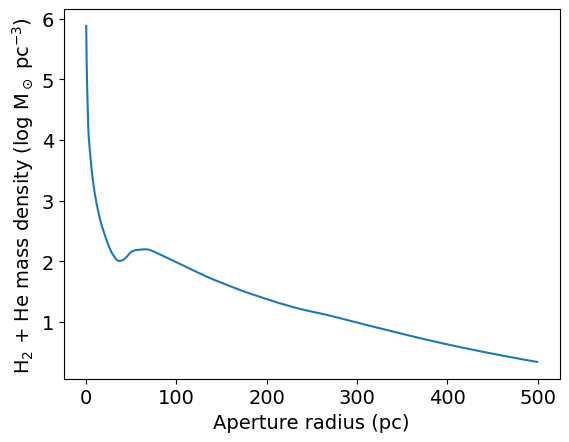

In [97]:
#aaaaaand lets plot molecular mass density here as well
plt.plot(sma_pc, np.log10(rho_norm))
plt.ylabel('H$_2$ + He mass density (log M$_\odot  \ \mathrm{pc}^{-3}$) ', fontsize = 14)
plt.xlabel('Aperture radius (pc)', fontsize = 14)

# Moving on to estimating the sound speed
Since we have data for the cold and warm gas, we can estimate the sound speed in each of these components
The equation for sound speed looks like:
$c_s = \sqrt{\frac{\gamma k_B T_{Kin}}{\mu m_p}}$ 
where $\gamma$ is the adiabatic index, k$_B$ is the Boltzmann constant, T$_{Kin}$ is the kinetic temperature, $\mu$ is the mean molecular mass, and m$_p$ is proton mass 

In each of these calculations we'll use:
- 1 as the adiabatic index because the gas is assumed to be isothermal in each sub-region
- the Boltzmann constant as 1.381 $\times$ 10$^{-16}$ erg $^{-1}$ K$^{-1}$ (in cm units)
- $\mu$ is the mean molecular weight of the gas, which is 2.7 since we assume the molecular gas is H$_2$, 10\% helium, and trace metals
- 1.67262192 $\times 10^{-24}$ g is proton mass
- Temperature is handled differently depending on the gas component in this tutorial. How it's handled in your project will depend on any measurements you find in the literature, and then any modeling you do following that investigation

This will output a number in cm/s which we'll then convert to km/s

# Estimating sound speed from the cold gas
We assume a constant temperature in this case

In [100]:
gamma = 1 #for locally isotropic gas
T_k = 50 #from CO rotation diagrams in Viti+14 (https://www.aanda.org/articles/aa/pdf/2014/10/aa24116-14.pdf)
e_T_k = 6
k = 1.38066e-16 #boltzmann constant
mu = 2.7 # molecular gas with 10% He and trace metals
m_p = 1.6726e-24 #proton mass, grams
c_s = np.sqrt(gamma*k*T_k/(mu*m_p))
e_c_s = np.sqrt(gamma*k*e_T_k/(mu*m_p)) 
c_s_km = c_s/1e5 #in km
e_c_s_km = e_c_s/1e5
c_s_B = c_s/1e2 #in m for later
e_c_s_B = e_c_s/1e2 #in m for later
print(str(c_s_km) + ' is the sound speed in km/s of H2+He')
print(str(c_s_B) + 'is the sound speed in m/s of H2+He')
print(str(e_c_s_B) + 'error in m/s')

0.39097631162413454 is the sound speed in km/s of H2+He
390.97631162413455is the sound speed in m/s of H2+He
135.43816725777663error in m/s


# Estimating sound speed from the warm gas
We assume an evolving temperature as a function of radius in this case

In [101]:
#the following arrays are kinetic temperatures based on excitation temperatures from Ming-Yi Lin. Below 0.2 arcseconds,
#the H2 1-0 S(1) and S(2) lines were not detected. See Agostino+25, Section 4.2 ('Direct Tests of Black Hole Accretion Rate 
#Prescriptions: I. Bondi Accretion at Different Scales')

temps = np.array([678.43,845.62,1028.99,1176.31,1485.65,1496.57,1665.88,1917.34,2022.66,1911.89,2030.18,2261.02,2189.89,2173.46,1822.09,1725.08])
e_temps_up = np.array([1205, 1199, 1432, 1346, 1890, 1568, 1899, 2732, 4130, 4547, 3785, 3683, 4618, 5294, 3146, 2960])
e_temps_down = np.array([472, 653, 803, 1045, 1224, 1431, 1484, 1477, 1339, 1210, 1387, 1631, 1435, 1367, 1282, 1217 ])
rad_arcsec_H2 = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7])
rad_pc_H2 = rad_arcsec_H2*pcperarcsec


T_k_H2 = np.mean(temps)
e_T_k_H2_up = np.mean(e_temps_up)
e_T_k_H2_down = np.mean(e_temps_down)


print(T_k_H2)
print(e_T_k_H2_up)
print(e_T_k_H2_down)


c_s_H2 = np.sqrt(gamma*k*temps/(mu*m_p))
e_c_s_H2_up = np.sqrt(gamma*k*e_temps_up/(mu*m_p))
e_c_s_H2_down = np.sqrt(gamma*k*e_temps_down/(mu*m_p))


c_s_km_H2 = c_s_H2/1e5 #in km/s
e_c_s_km_H2_up = e_c_s_H2_up/1e5 #in km/s
e_c_s_km_H2_down = e_c_s_H2_down/1e5 #in km/s

c_s_B_H2 = c_s_H2/1e2 #in m/s
e_c_s_B_H2_up = e_c_s_H2_up/1e2 #in m/s
e_c_s_B_H2_down = e_c_s_H2_down/1e2 #in m/s

print(str(c_s_B_H2) + ' are the sound speeds of H2 in m/s')

1651.9412499999999
2839.625
1216.0625
[1440.18394494 1607.87790064 1773.66264796 1896.38424081 2131.19749363
 2139.01564316 2256.7700013  2421.11272028 2486.71999314 2417.66928971
 2491.33836335 2629.16380644 2587.47756751 2577.75281062 2360.20842026
 2296.51910739] is the sound speed of H2 in m/s


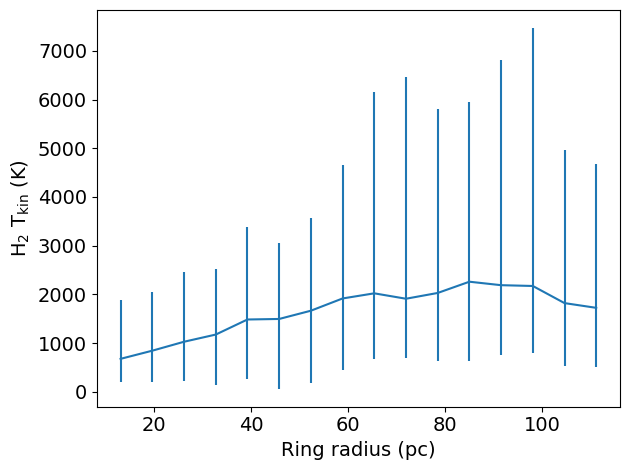

In [102]:
#plot temperature as a function of radius
plt.figure()
plt.errorbar(rad_pc_H2, temps, yerr = [e_temps_down, e_temps_up])
plt.ylabel('H$_2$ T$_{\mathrm{kin}}$ (K)', fontsize = 14)
plt.xlabel('Ring radius (pc)', fontsize = 14)
plt.tight_layout()

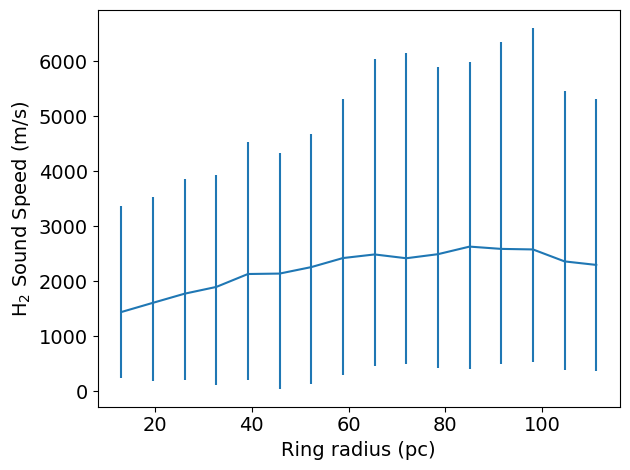

In [105]:
#plot sound speed as a function of radius
plt.figure()
plt.errorbar(rad_pc_H2, c_s_B_H2, yerr = [e_c_s_B_H2_down, e_c_s_B_H2_up])
plt.ylabel('H$_2$ Sound Speed (m/s)', fontsize = 14)
plt.xlabel('Ring radius (pc)', fontsize = 14)
plt.tight_layout()

# Now we want to calculate the Bondi accretion rate at various measured distances
$\dot{M}_{Bondi}$ = 4$\pi$$G^2$$M_{BH}^2$$\rho_{gas}$c$_s^{-3}$ [M$_\odot$ yr$^{-1}$] (Hopkins+16: https://ui.adsabs.harvard.edu/abs/2016MNRAS.458..816H/abstract)

In [111]:
#For full range of aperture sizes, spherical volume element, with the cold gas sound speed
G = 6.6743e-11
msolar = 1.99e30
M_BH = 1e7 #BH mass from Greenhill 1996 H20 maser model, measured at 0.65 pc, sub-Keplerian velocities
M_BH_B = M_BH*msolar #we want this in kg for the Bondi equation
#use your own BH mass from literature or derived via CO or K-Band kinematics if there's rotation you can measure

C = 4*np.pi*(M_BH_B**2)*G**2 #constants in one variable to make below less of a pain
m_bondi_s_sphere = C*np.array(rho_B)*(c_s_B**-3)
e_bondi_s_sphere = np.sqrt((((C*c_s_B**-3)**2)*(np.array(e_rho_B))**2) + (((-3*C*(c_s_B**-4)*np.array(rho_B))**2)*(e_c_s_B)**2))
#e_bondi_s_sphere is in kg s^-1, need to convert to solar
m_bondi_s_sphere = m_bondi_s_sphere/msolar #putting this is msolar units
e_m_bondi_s_sphere = e_bondi_s_sphere/msolar #putting this is msolar units
m_bondi_yr_sphere_T_CO = m_bondi_s_sphere*(3.154e7)
e_m_bondi_yr_sphere_T_CO = e_m_bondi_s_sphere*(3.154e7)
r_test = 93 #change this if you want a quick look at another r
print(str(sma_pc[r_test])+' pc aperture radius') 
print(str(m_bondi_yr_sphere_T_CO[r_test]) + ' Bondi accretion rate (solar masses per year) at 20 pc')
print(str(e_m_bondi_yr_sphere_T_CO[r_test]) + ' Error on Bondi accretion rate (solar masses per year) at 20 pc')


19.972979000000002 pc aperture radius
[1.16609325e+08] Bondi accretion rate (solar masses per year) at 20 pc
[1.28443286e+08] Error on Bondi accretion rate (solar masses per year) at 20 pc


In [116]:
#same as above but with H2 c_s and mass
G = 6.6743e-11
M_gas_H2 = msolar*68 #68 solar masses is from using the H2 1-0 S(1) transition flux
#equation used for that comes from Storchi+09 (https://ui.adsabs.harvard.edu/abs/2009MNRAS.394.1148S/abstract)
rho_B_H2 = M_gas_H2/(4/3*np.pi*(rad_pc_H2*3.086e16)**3)

m_bondi_s_sphere_H2 = C*np.array(rho_B_H2)*(c_s_B_H2**-3)
m_bondi_s_sphere_H2 = m_bondi_s_sphere_H2/msolar #put this is msolar
e_bondi_s_sphere_H2_up = np.sqrt((((-3*C*(c_s_B_H2**-4)*np.array(rho_B_H2))**2)*(e_c_s_B_H2_up)**2))
e_bondi_s_sphere_H2_down = np.sqrt((((-3*C*(c_s_B_H2**-4)*np.array(rho_B_H2))**2)*(e_c_s_B_H2_down)**2))
e_bondi_s_sphere_H2_up_F = np.sqrt((((-3*C*(c_s_B_H2**-4)*np.array(rho_B_H2))**2)*(e_c_s_B_H2_up)**2))/msolar*(3.154e+7)
e_bondi_s_sphere_H2_down_F = np.sqrt((((-3*C*(c_s_B_H2**-4)*np.array(rho_B_H2))**2)*(e_c_s_B_H2_down)**2))/msolar*(3.154e+7)
m_bondi_yr_sphere_T_H2 = m_bondi_s_sphere_H2*(3.154e+7)
r_test = 1 #index 1 for ~20 pc for the H2 radius steps
print(str(rad_pc_H2[r_test])+' pc aperture radius') 
print(str(m_bondi_yr_sphere_T_H2[r_test]) + ' Bondi accretion rate (solar masses per year) at 20 pc')

19.613400000000002 pc aperture radius
12.314132901519727 Bondi accretion rate (solar masses per year) at 20 pc


Text(0.5, 0, 'Ring radius (pc)')

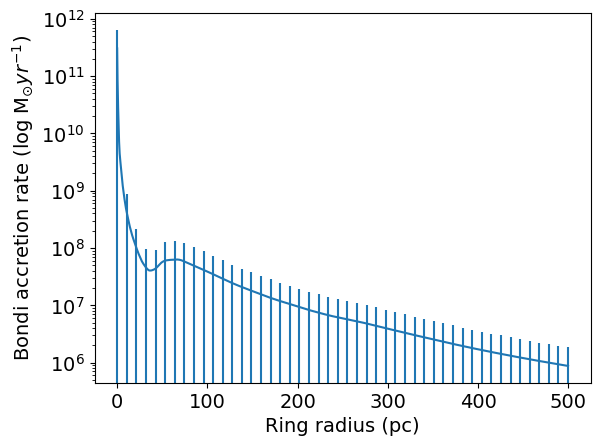

In [134]:
#lets make a couple figures to take a quick look at the results!

#Bondi accretion rate as a function of radius with spherical volume (cold gas)
e_test_mbondi = []
test_mbondi = []
sma_test = []
for i in range(len(e_m_bondi_yr_sphere_T_CO)):
    test_mbondi.append(float(m_bondi_yr_sphere_T_CO[i]))
    e_test_mbondi.append(float(e_m_bondi_yr_sphere_T_CO[i]))
    sma_test.append(float(sma_pc[i]))
plt.errorbar(sma_test, test_mbondi, xerr = None, yerr = e_test_mbondi, errorevery = 50)
plt.yscale('log')
plt.ylabel('Bondi accretion rate (log $\mathrm{M}_{\odot} yr^{-1}$)', fontsize = 14)
plt.xlabel('Ring radius (pc)', fontsize = 14)

Text(0.5, 0, 'Aperture radius (pc)')

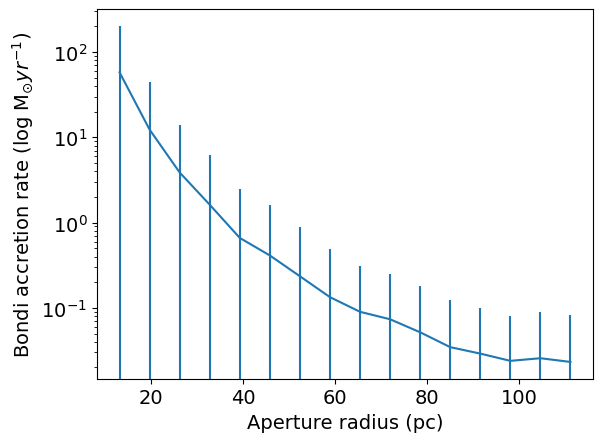

In [135]:
#Bondi accretion rate as a function of radius with spherical volume (warm gas)
plt.errorbar(rad_pc_H2, m_bondi_yr_sphere_T_H2, yerr = [e_bondi_s_sphere_H2_up_F,e_bondi_s_sphere_H2_down_F])
plt.yscale('log')
plt.ylabel('Bondi accretion rate (log $\mathrm{M}_{\odot} yr^{-1}$)', fontsize = 14)
plt.xlabel('Aperture radius (pc)', fontsize = 14)

# Time to compare to X-ray derived BH accretion rate
logLbol = [log(L$_{Xray}$) - (0.13 * log(L$_{Edd}$)+1.04)] /0.87
Derived from the bolometric correction of Gupta+24 (https://ui.adsabs.harvard.edu/abs/2024A%26A...691A.203G/abstract)

I've tried to include all of the context but if you have additional questions on this shoot me an email (either james.agostino@rockets.utoledo.edu or j.agostino202@gmail.com) 

In [152]:
c = 3e8 #speed of light
xraylumlog = 42.82 #intrinsic luminosity from BASS (Ricci+17; https://ui.adsabs.harvard.edu/abs/2018yCat..22330017R/abstract)
#go to Vizier and query for your target!
xraylum = 10**xraylumlog 
xraylumdex = (xraylum*10)-xraylum #1 dex above xraylum for comparison
e_xraylum = 0.4*xraylumdex #0.4 dex above xray lum -- for sources with logNH>23.5. If lower, use 0.1 dex
#for the above, C. Ricci says this is a conservative approach, which takes into account that the continuum
#might not be well estimated when the X-ray emission is dominated by reprocessed radiation, and the 
#photon index (and column density) strongly propagates into the uncertainty in the luminosity
e_xraylumlog = np.log10(e_xraylum)
logmbh = 6.93 #from https://ui.adsabs.harvard.edu/abs/2022ApJS..261....2K/abstract
eddlum = (3.2e4)*(10**logmbh) #in solar luminosities, for H+, https://en.wikipedia.org/wiki/Eddington_luminosity
eddlumlog = np.log10((3.846e33)*eddlum) #converting from solar lum to erg s-1
print(str(eddlumlog)+' log Eddington luminosity')
#Bolometric correction reported in Gupta+24 Eqn 17, solve for logLbol (bolo correction is L_bol/L_lambda)
#https://ui.adsabs.harvard.edu/abs/2024A%26A...691A.203G/abstract
logLbol = (xraylumlog-(0.13*eddlumlog)+1.04)/0.87
e_logLbol = np.sqrt(e_xraylumlog**2+(0.04**2)*(eddlumlog**2) + (0.05)**2)
print(str(logLbol)+' log bolometric luminosity in erg/s')
print(str(e_logLbol)+' error on log bolometric luminosity in erg/s')

eddratebol = (eddlumlog-(0.13*eddlumlog)+1.04)/0.87

medd = 10**eddlumlog/0.1/c**2/msolar #Eddington accretion rate (Msolar/yr), for a thin accretion disc e.g. as found in (https://iopscience.iop.org/article/10.1086/305845/fulltext/37344.text.html)
print(str(medd) + ' Eddington accretion rate in solar masses per yr')

45.020159258222364 log Eddington luminosity
43.686642869461025 log bolometric luminosity in erg/s
43.413696251545865 error on log bolometric luminosity in erg/s
0.05848758271225133 Eddington accretion rate in solar masses per yr


In [159]:
#now lets convert to an accretion rate
#eqn for mdot can be derived from the equation under equation 3 in 

#Netzer & Trakhtenbrot https://academic.oup.com/mnras/article/438/1/672/1039781
#three BH spins: a = 0 (stationary BH, η = 0.057), a = −1 (retrograde
#disc, η = 0.038) and a = 0.998 (maximally rotating BH, η = 0.32) also from N & T

#Below is for a stationary black hole


eta = 0.057 #stationary smbh
conv = 1e7 #1 erg is 1e-7 Jy
LbolJ = (10**logLbol)*conv #1 erg = 10^-7 J so 1 J\ = 10^7 erg
e_LbolJ = (10**e_logLbol)*conv
Mdot = LbolJ/eta/c**2 
#Lbol*eta^-1*c^-2 gives erg s-1 = kg m2 s-3 so we multiply by c^-2  [m^-2s^2] which gives kg s-1
#highly recommend running through this algebra to understand the unit conversions so you can trust your work!
e_Mdot = e_LbolJ/eta/c**2
Mdotyr = Mdot/3.154e+7 #kg yr-1 (converting per second to per yr)
Mdotsolar = Mdotyr/1.99e30 #Msun yr-1 (converting kg second to solar masses)
e_Mdotyr = e_Mdot/3.154e+7 #kg yr-1
e_Mdotsolar = e_Mdotyr/1.99e30 #Msun yr-1
Mdotsolar_up = Mdotsolar+e_Mdotsolar
Mdotsolar_down = Mdotsolar-e_Mdotsolar
xray_mdot_array = np.ones(len(sma_pc))*Mdotsolar # for plotting
e_xray_mdot_array = np.ones(len(sma_pc))*e_Mdotsolar
print(str(Mdotsolar) + ' accretion rate for a stationary BH using X-ray luminosity' )
print(str(e_Mdotsolar) + ' uncertainty on the above')

0.001509422220187517 accretion rate for a stationary BH using X-ray luminosity
0.0008051264995356187 uncertainty on the above


In [160]:
#Below is for a retrograde disc


eta2 = 0.038 #retrograde disc
Mdot2 = LbolJ/eta2/c**2 
e_Mdot2 = e_LbolJ/eta2/c**2
Mdotyr2 = Mdot2/3.154e+7 #kg yr-1
Mdotsolar2 = Mdotyr2/1.99e30 #Msun yr-1
e_Mdotyr2 = e_Mdot2/3.154e+7 #kg yr-1
e_Mdotsolar2 = e_Mdotyr2/1.99e30 #Msun yr-1
Mdotsolar2_up = Mdotsolar2+e_Mdotsolar2
Mdotsolar2_down = Mdotsolar2-e_Mdotsolar2
xray_mdot_array2 = np.ones(len(sma_pc))*Mdotsolar2 # for plotting
e_xray_mdot_array2 = np.ones(len(sma_pc))*e_Mdotsolar2

print(str(Mdotsolar2) + ' accretion rate for a retrograde accretion disc using X-ray luminosity' )
print(str(e_Mdotsolar2) + ' uncertainty on the above')

0.0022641333302812756 accretion rate for a retrograde accretion disc using X-ray luminosity
0.0012076897493034282 uncertainty on the above


In [161]:
#Below is for a maximally rotating black hole

eta3 = 0.32 #maximally rotating, eta = 0.32
Mdot3 = LbolJ/eta3/c**2 
e_Mdot3 = e_LbolJ/eta3/c**2
Mdotyr3 = Mdot3/3.154e+7 #kg yr-1
Mdotsolar3 = Mdotyr3/1.99e30 #Msun yr-1
e_Mdotyr3 = e_Mdot3/3.154e+7 #kg yr-1
e_Mdotsolar3 = e_Mdotyr3/1.99e30 #Msun yr-1
Mdotsolar3_up = Mdotsolar3+e_Mdotsolar3
Mdotsolar3_down = Mdotsolar3-e_Mdotsolar3
xray_mdot_array3 = np.ones(len(sma_pc))*Mdotsolar3 # for plotting
e_xray_mdot_array3 = np.ones(len(sma_pc))*e_Mdotsolar3

print(str(Mdotsolar3) + ' accretion rate for a maximally rotating BH using X-ray luminosity' )
print(str(e_Mdotsolar3) + ' uncertainty on the above')

0.0002688658329709015 accretion rate for a maximally rotating BH using X-ray luminosity
0.0001434131577297821 uncertainty on the above


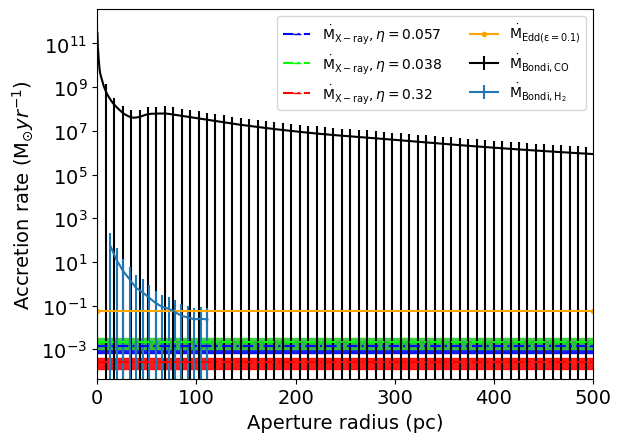

In [163]:
#Lets plot the final comparison! Change anything below to what you prefer for your figure format
#initializing arrays for the bondi rates for the cold gas as we've done before
a = []
b = []
errs = []
for i in range(len(e_m_bondi_yr_sphere_T_CO)):
    a.append(float(sma_pc[i]))
    b.append(float(m_bondi_yr_sphere_T_CO[i]))
    errs.append(float(e_m_bondi_yr_sphere_T_CO[i]))


fig = plt.figure()
ax = fig.subplots()
ax.errorbar(a, b, yerr = errs,color ='black', errorevery =40,  label = '$\mathrm{\dot{M}}_{\mathrm{Bondi, CO}}$', alpha = 1)
ax.errorbar(rad_pc_H2, m_bondi_yr_sphere_T_H2, yerr = [e_bondi_s_sphere_H2_up_F,e_bondi_s_sphere_H2_down_F], label = '$\mathrm{\dot{M}}_{\mathrm{Bondi, H_2}}$')

xrayrange = pltRectangle([0,Mdotsolar_down], 500, e_Mdotsolar*2, alpha = 0.9, color = 'blue')
xrayrange2 = pltRectangle([0,Mdotsolar2_down], 500, e_Mdotsolar2*2, alpha = 0.9, color = 'limegreen')
xrayrange3 = pltRectangle([0,Mdotsolar3_down], 500, e_Mdotsolar3*2, alpha = 0.9, color = 'red')

ax.add_artist(xrayrange)
ax.add_artist(xrayrange3)

ax.add_artist(xrayrange2)

ax.axhline(Mdotsolar, marker = '_', dashes = (5, 2, 1, 2), label = '$\mathrm{\dot{M}}_\mathrm{X-ray}, \eta = 0.057$', color = 'blue')
ax.axhline(Mdotsolar2, marker = '_', dashes = (5, 2, 1, 2),label = '$\mathrm{\dot{M}}_\mathrm{X-ray}, \eta = 0.038$', color = 'lime')
ax.axhline(Mdotsolar3, marker = '_', dashes = (5, 2, 1, 2),label = '$\mathrm{\dot{M}}_\mathrm{X-ray}, \eta = 0.32$', color = 'red')
ax.axhline(medd, marker = '.', label = '$\mathrm{\dot{M}}_\mathrm{Edd (\epsilon = 0.1)}$', color = 'orange')
plt.ylabel('Accretion rate ($\mathrm{M}_{\odot} yr^{-1}$)', fontsize = 14)
plt.xlabel('Aperture radius (pc)', fontsize = 14)
plt.yscale('log')
plt.legend(ncol = 2, loc = 1, fontsize = 10)
plt.xlim(0,500)

plt.savefig(figure_path + 'Bondi_xray_temp',dpi=300, bbox_inches='tight')